In [1]:
# IMPORTS
import tensorflow as tf 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve # for part 3b

In [8]:
# PREPROCESSING - LOADING DATA
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# DEFINING DIRECTORY
common_path = "/Users/michaelpatsais/Documents/Uni_work/machine_learning/deep-learning-2024/Project/msl-images/"
save_directory = "/Users/michaelpatsais/Documents/Uni_work/machine_learning/deep-learning-2024/Project/plots_to_save"

idg = ImageDataGenerator(rescale = 1./255.)

# LABELS DF
image_classes = np.loadtxt(common_path + "msl_synset_words-indexed.txt", dtype = str, delimiter = ",")
labels_df = pd.DataFrame(image_classes, columns = ["filename", "class"])

# no_rover = [5, 8, 9, 22]
# for i, line in labels_df.iterrows():
#     if int(line["filename"]) in no_rover:
#         labels_df.at[i, "filename"] = "0"
#         labels_df.at[i, "class"] = "no_rover"
#     else:
#         labels_df.at[i, "filename"] = "1"
#         labels_df.at[i, "class"] = "rover"

labels = labels_df["class"].unique().tolist()
labels = [x.strip() for x in labels]
print(labels)

classes = np.arange(len(labels))
classes = [str(x) for x in classes]
print(classes)

# train DF
train = np.loadtxt(common_path + "train-calibrated-shuffled.txt", dtype = str, delimiter = " ")
train_df = pd.DataFrame(train, columns = ["filename", "class"])

# for i, line in train_df.iterrows():
#     if int(line["class"]) in no_rover:
#         train_df.at[i, "class"] = "0"
#     else:
#         train_df.at[i, "class"] = "1"

train_ds = idg.flow_from_dataframe(dataframe = train_df, directory = common_path, classes = classes, batch_size = 100)

# VAL DF
val = np.loadtxt(common_path + "val-calibrated-shuffled.txt", dtype = str, delimiter = " ")
val_df = pd.DataFrame(val, columns = ["filename", "class"])

# for i, line in val_df.iterrows():
#     if int(line["class"]) in no_rover:
#         val_df.at[i, "class"] = "0"
#     else:
#         val_df.at[i, "class"] = "1"

val_ds = idg.flow_from_dataframe(dataframe = val_df, directory = common_path, classes = classes, batch_size = 100)

# TEST DF
test = np.loadtxt(common_path + "test-calibrated-shuffled.txt", dtype = str, delimiter = " ")
test_df = pd.DataFrame(test, columns = ["filename", "class"])

# for i, line in train_df.iterrows():
#     if int(line["class"]) in no_rover:
#         test_df.at[i, "class"] = "0"
#     else:
#         test_df.at[i, "class"] = "1"

test_ds = idg.flow_from_dataframe(dataframe = test_df, directory = common_path, classes = classes, batch_size = 100)

['apxs', 'apxs cal target', 'chemcam cal target', 'chemin minlet open', 'drill', 'drill holes', 'drt front', 'drt side', 'ground', 'horizon', 'inlet', 'mahli', 'mahli cal target', 'mastcam', 'mastcam cal target', 'observation tray', 'portion box', 'portion tube', 'portion tube opening', 'rems uv sensor', 'rover rear deck', 'scoop', 'sun', 'turret', 'wheel']
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24']
Found 3746 validated image filenames belonging to 25 classes.
Found 1640 validated image filenames belonging to 25 classes.
Found 1305 validated image filenames belonging to 25 classes.


In [10]:
#  MODEL CONFIGURATION
batch_size = 100
epochs = 3
dropout_val = 0

xpix = train_ds[0][0][0].shape[0]
ypix = train_ds[0][0][0].shape[1]
zpix = train_ds[0][0][0].shape[2]

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(xpix, ypix, zpix)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(dropout_val),
    # tf.keras.layers.Dense(2, activation='softmax')
    tf.keras.layers.Dense(25, activation='softmax')
])

model.summary()

# now specify the loss function - cross entropy
# loss_fn = tf.keras.losses.BinaryCrossentropy()
loss_fn = tf.keras.losses.CategoricalCrossentropy()

# now we can train the model to make predictions.
#   Use the ADAM optimiser
#   Specify the metrics to report as accuracy
#   Specify the loss function (see above)
# the fit step specifies the number of training epochs
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
history  = model.fit(train_ds, validation_data=val_ds, batch_size=batch_size, epochs=epochs)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 127, 127, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 246016)            0         
                                                                 
 dense_4 (Dense)             (None, 64)               

  N(Epochs)        =  3
  accuracy (train) =  [0.6051788330078125, 0.8483716249465942, 0.9329952001571655]
  accuracy (test)  =  [0.12134146690368652, 0.4987804889678955, 0.30914634466171265]


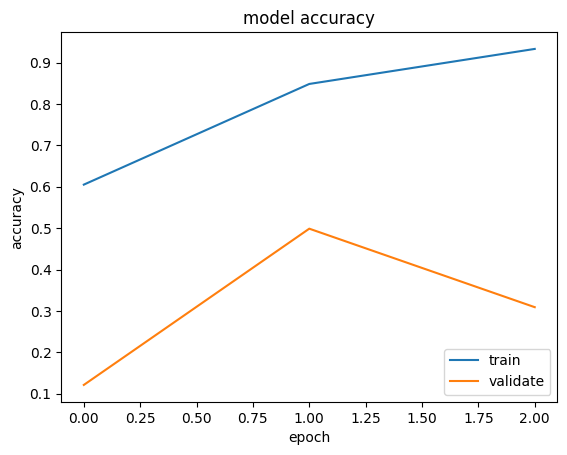

  N(Epochs)        =  3
  loss (train)     =  [2.5217251777648926, 0.5908430814743042, 0.25553399324417114]
  loss (test)      =  [3.109776258468628, 2.637803316116333, 3.6655588150024414]


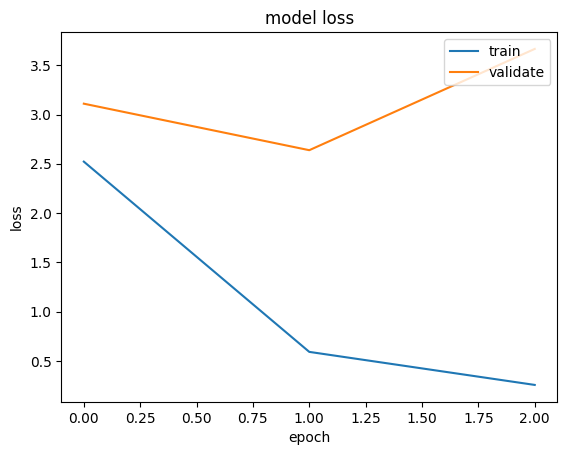

In [16]:
# PART 2A

print("  N(Epochs)        = ", epochs)
print("  accuracy (train) = ", history.history['accuracy'])
print("  accuracy (test)  = ", history.history['val_accuracy'])
print("  loss (train)     = ", history.history['loss'])
print("  loss (test)      = ", history.history['val_loss'])

plt.plot(history.history['accuracy']) # 'accuracy'
plt.plot(history.history['val_accuracy']) # 'val_accuracy'
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='lower right')
plt.savefig(save_directory + "/Multi_Classification_model_accuracy.png")
# plt.savefig(save_directory + "/Binary_Classification_model_accuracy")
plt.show()

# summarize history for loss
plt.plot(history.history['loss']) # 'loss'
plt.plot(history.history['val_loss']) # 'val_loss'
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.savefig(save_directory + "/Multi_Classification_model_loss")
# plt.savefig(save_directory + "/Binary_Classification_model_loss")
plt.show()

In [ ]:
# pred = model.predict(x_test)
# print(pred.shape)

# for i in range(len(x_test)):
#     if np.argmax(pred[i]) == y_test[i]:  # pred[i] is each batch?
#         continue
#     else:
#         print( i, y_test[i], np.argmax(pred[i]))
#         plt.imshow(x_test[i])
#         plt.colorbar()
#         plt.show()
#         print("-----------------------------------------------")


#  accuracy still increasing, loss still decreasing => epochs can be increased
# erratic loss => learning rate too high
# training data outperforming test data = overfitting => increase dropout value
# with a large dataset, a larger batch size is better than a small one to avoid model optimising too many times


14/14 [==============================] - 28s 2s/step


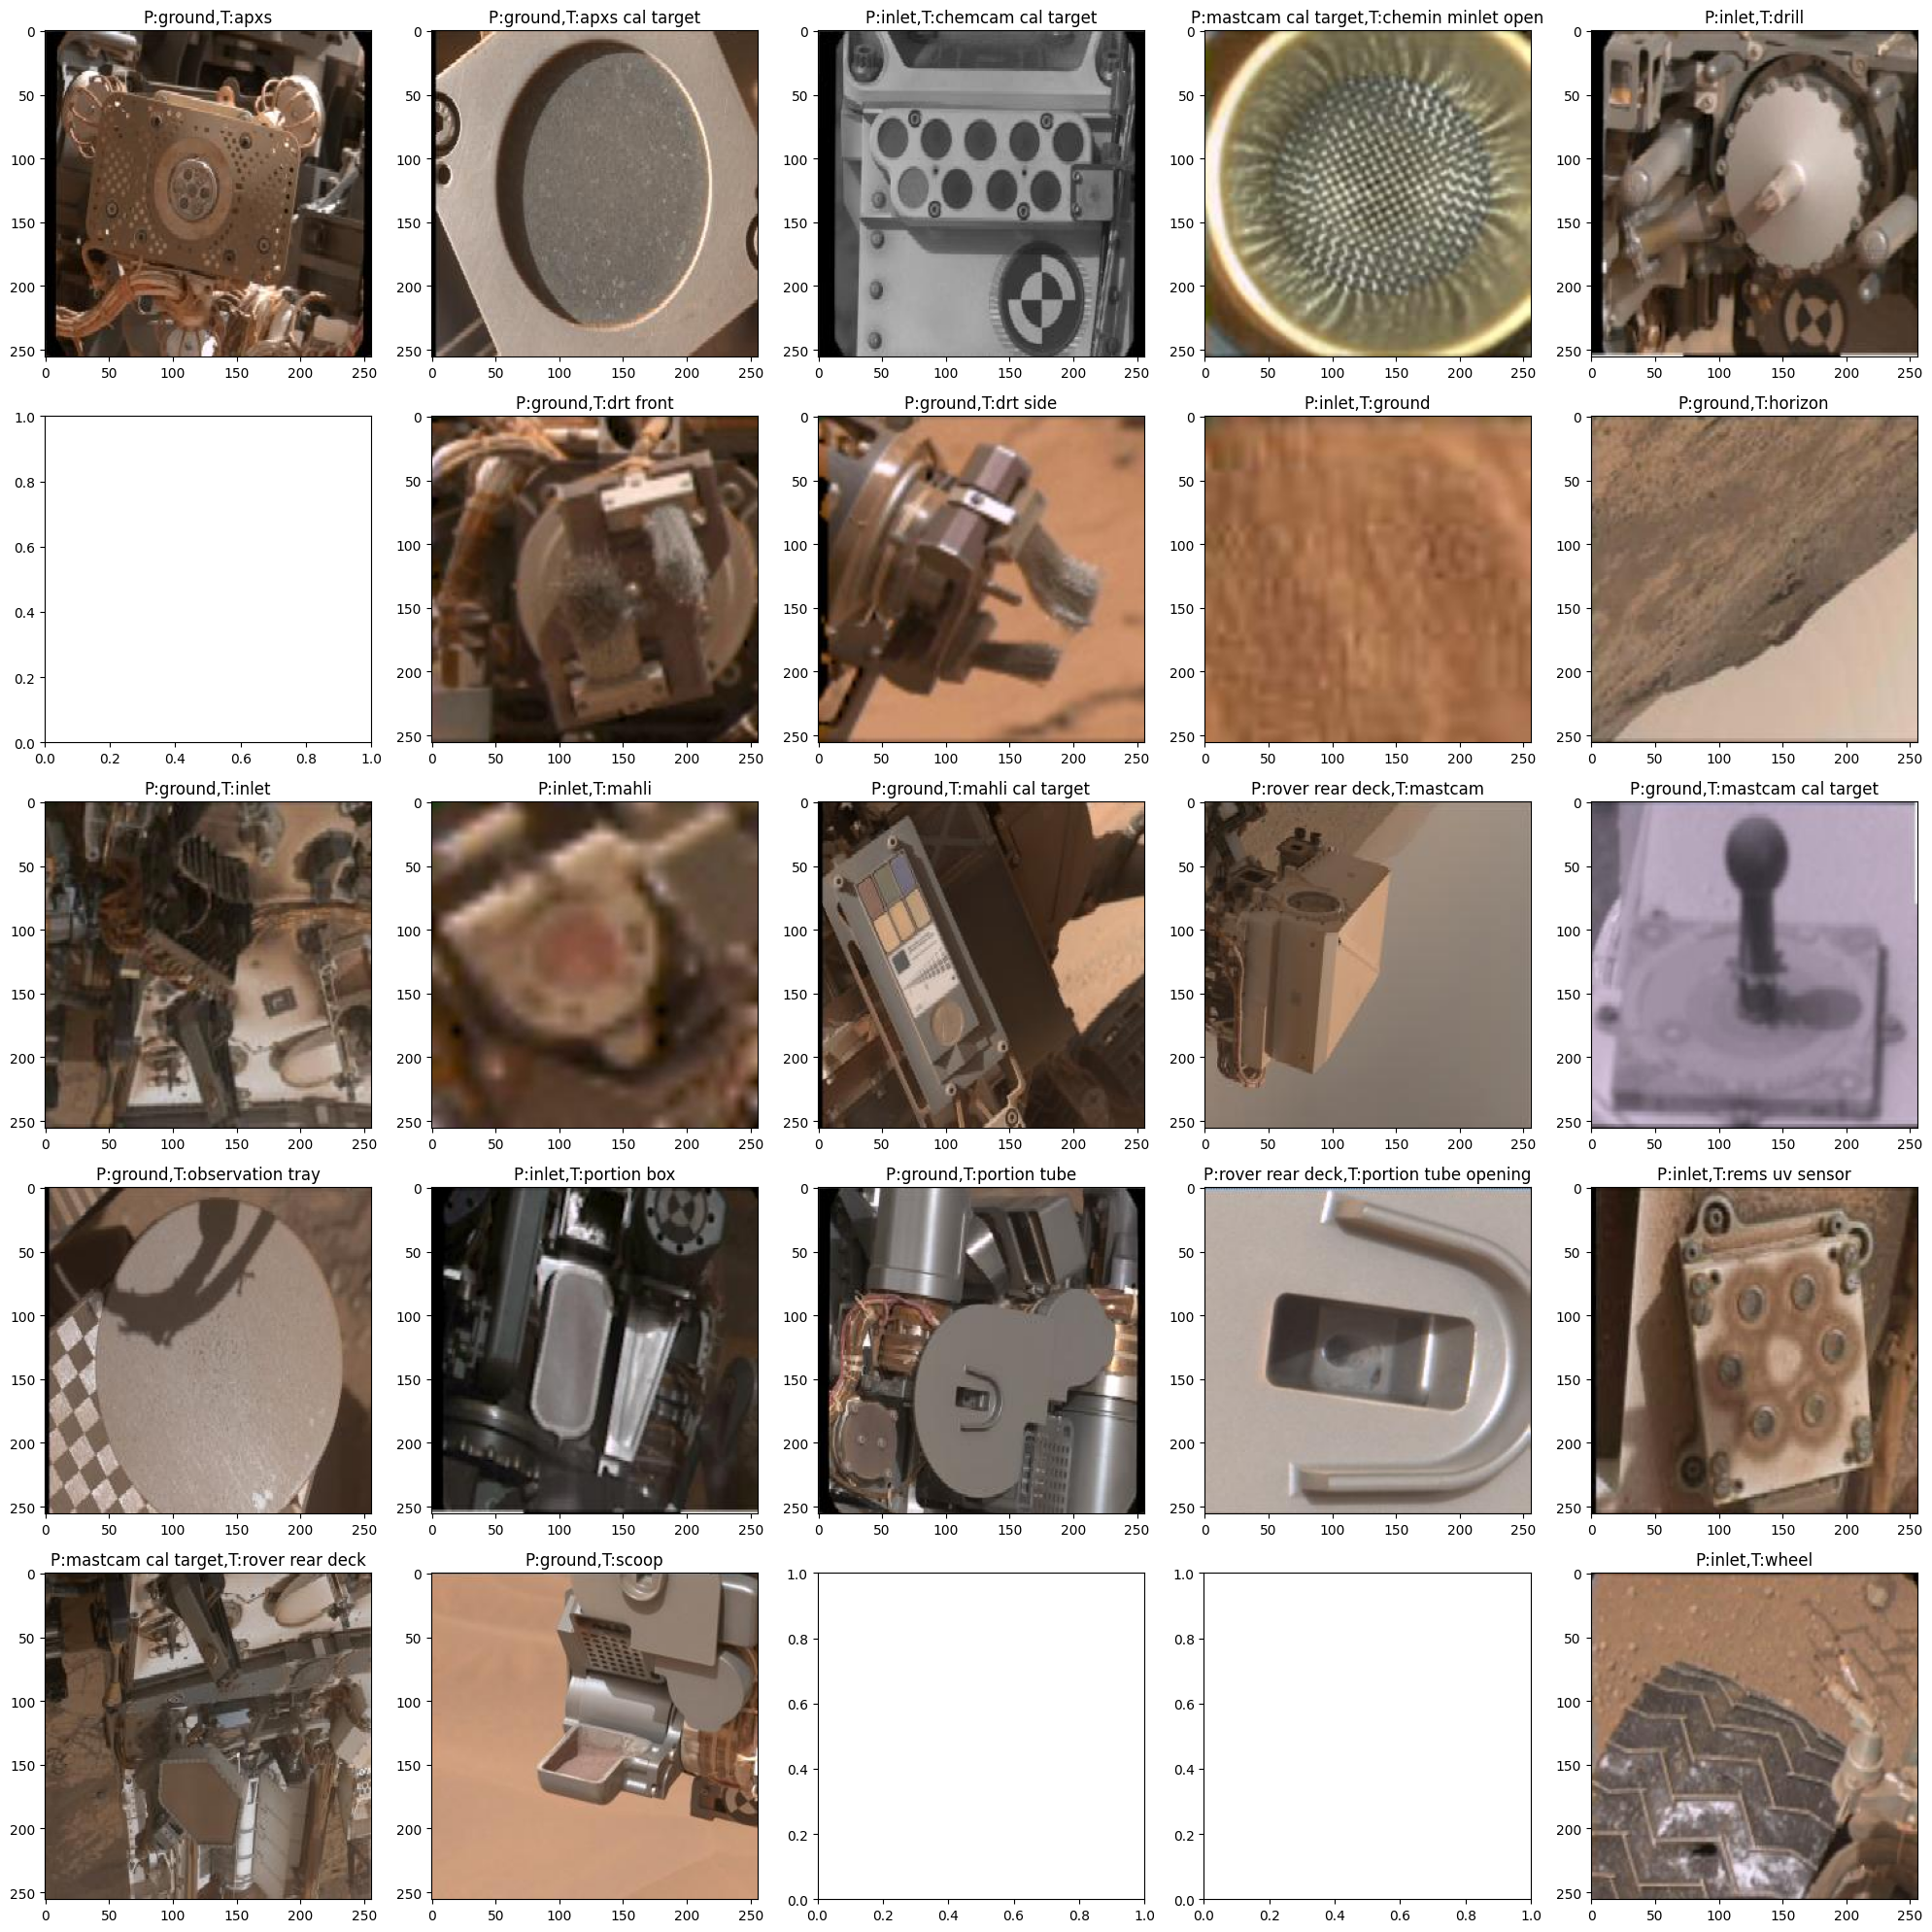

In [17]:
# PART 2B
predictions = model.predict(test_ds)

# combining batches
all_images = np.concatenate([test_ds[batch][0] for batch in range(len(test_ds))])
all_images_data = np.concatenate([test_ds[batch][1] for batch in range(len(test_ds))])

fig, axes = plt.subplots(5, 5, figsize = (20,20))
            
for i in range(25):
    ax = axes[i//5, i%5]
    for image in range(len(all_images_data)):
        if (np.argmax(all_images_data[image]) != i):
            continue
        else:
            ax.set_title(f"P:{labels[np.argmax(predictions[image])]},T:{labels[i]}")
            ax.imshow(all_images[image])
            break
plt.tight_layout()        
plt.savefig(save_directory + "/2b.png")
plt.show()

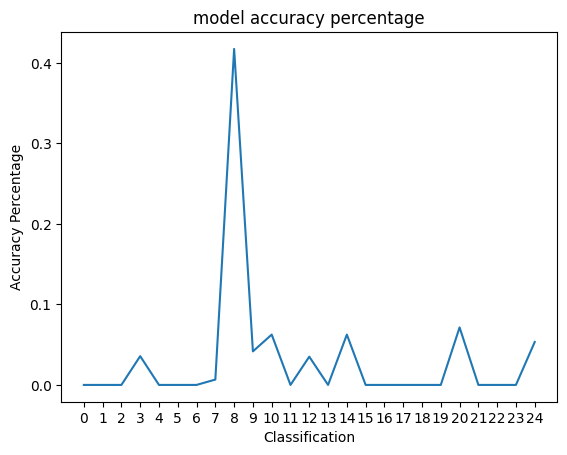

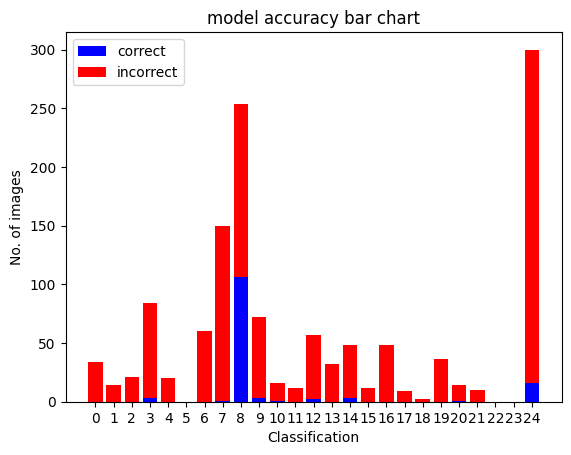

In [33]:
# PART 2C

classifications = [[] for _ in range(25)]

for i, image_data in enumerate(all_images_data):
    true_val = int(np.argmax(image_data))
    pred_val = int(np.argmax(predictions[i]))
    
    if true_val == pred_val:
        classifications[true_val].append("correct")
    else:
        classifications[true_val].append("incorrect")

correct = [classification.count("correct") for classification in classifications]
incorrect = [classification.count("incorrect") for classification in classifications]
x_axis = np.arange(len(classifications))

accuracy_perc = []

for correct_count, incorrect_count in zip(correct, incorrect):
    total = correct_count+incorrect_count
    if total > 0:
        acc = correct_count/total
    else: 
        acc = 0 
    accuracy_perc.append(acc)

plt.plot(accuracy_perc)
plt.title('model accuracy percentage')
plt.ylabel('Accuracy Percentage')
# plt.yticks(range(max(correct)+max(incorrect)))
plt.xlabel('Classification')
plt.xticks(range(len(classes)))
plt.savefig(save_directory + "/2c_accuracy.png")
plt.show()

plt.figure()
plt.bar(x_axis, correct, color = "blue")
plt.bar(x_axis, incorrect, bottom = correct, color = "red")
plt.title('model accuracy bar chart')
plt.ylabel('No. of images')
# plt.yticks(range(max(correct)+max(incorrect)))
plt.xlabel('Classification')
plt.xticks(range(len(classes)))
plt.legend(['correct', 'incorrect'], loc='upper left')
plt.savefig(save_directory + "/2c.png")
plt.show()


In [ ]:
#  part 3b
FPR, TPR, thresholds = roc_curve(all_images_data[:,1], predictions[:,1])

plt.plot(FPR, TPR)
# plt.plot([0,1], [0,1])
plt.title = ("Binary-Classification Model ROC Curve")
plt.xlabel = ("flse positive rate")
plt.ylabel = ("true positive rate")
plt.savefig(save_directory + "/3b.png")
plt.show()